Dataset Shape: (284807, 31)
Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64
Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Before SMOTE: Class
0    284315
1       492
Name: count, dtype: int64
After SMOTE: Class
0    284315
1    284315
Name: count, dtype: int64

Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.9477281653565002
ROC AUC: 0.9893658355356391
Confusion Matrix:
 [[83213  2082]
 [ 6835 78459]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95     85295
           1       0.97      0.92      0.95     8529

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:21:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
Accuracy: 0.9996658635668185
ROC AUC: 0.999995009657345
Confusion Matrix:
 [[85238    57]
 [    0 85294]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      1.00      1.00     85294

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



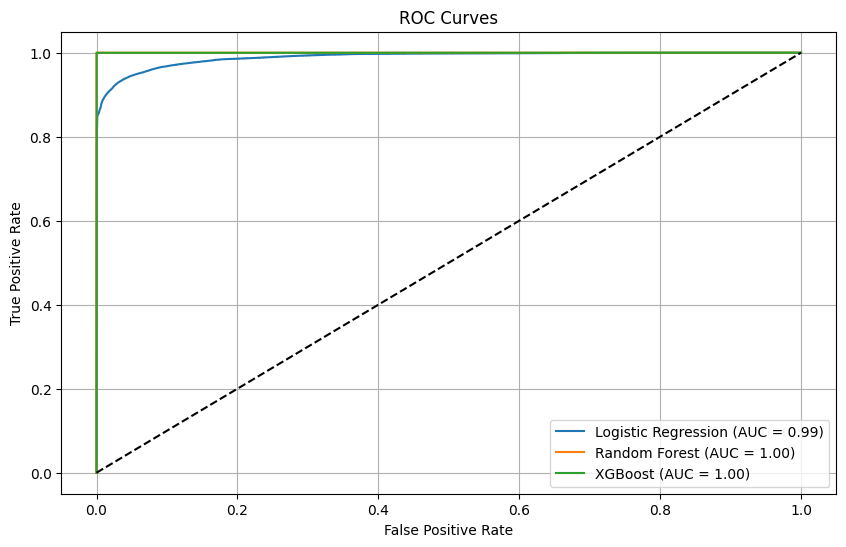

In [ ]:

!pip install -q xgboost imbalanced-learn


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE


df = pd.read_csv('/content/creditcard.csv')  # Update this path if using your Google Drive

# Basic info
print("Dataset Shape:", df.shape)
print("Class distribution:\n", df['Class'].value_counts())

# Check for null values
print("Missing values:\n", df.isnull().sum())

# Features and target
X = df.drop(['Class'], axis=1)
y = df['Class']

# Standardize the 'Amount' and 'Time' features
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Handle class imbalance with SMOTE
print("Before SMOTE:", y.value_counts())
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print("After SMOTE:", pd.Series(y_res).value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

# Define and train models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[name] = {
        "Confusion Matrix": cm,
        "Classification Report": cr,
        "ROC AUC": roc_auc,
        "Model": model
    }

    print(f"{name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot ROC curves
plt.figure(figsize=(10, 6))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result["Model"].predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["ROC AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
